# Generalization to Bayesian Softmax Regression

Ref: Chap 4 of Mar18

https://cfteach.github.io/brds/referencesmd.html

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az
import requests
import io 

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/iris.csv' 

download = requests.get(target_url).content
iris = pd.read_csv(io.StringIO(download.decode('utf-8')))

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Recipe 1: Dealing with correlated data

/var/folders/r2/_2532dgx683084s9v9ss0cfc0000gq/T/ipykernel_21894/3442237557.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = iris[iris['species'] != 'virginica'].corr()


[Text(0, 0.5, 'sepal_length'),
 Text(0, 1.5, 'sepal_width'),
 Text(0, 2.5, 'petal_length'),
 Text(0, 3.5, 'petal_width')]

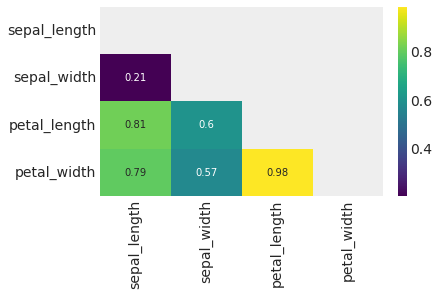

In [5]:
corr = iris[iris['species'] != 'virginica'].corr() 
mask = np.tri(*corr.shape).T 
g = sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
g.set_xticklabels(g.get_yticklabels(), rotation = 90, fontsize = 14)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 14)



<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Notes</b><br>
    <p style="color: black">
        (i) Correlated data has typically less power to restrict the model; correlated variables translate into wider combinations of coefficients that are able to explain the data.
    </p>
    <p  style="color: black">
       (ii) One solution when dealing with highly correlated variables is to remove one (or more than one) correlated variable.
    </p>
    <p  style="color: black">
        (iii) Another option is scaling all non-binary variables to have a mean of 0, and then using:
    </p>    
    <center>
        $\beta \sim StudentT(0,\nu,sd)$
    </center>
    <p  style="color: black">
    $sd$ should be chosen to weekly inform us about the expected value for the scale. The normality parameter $\nu$ is typically chosen to be in the range (3,7). 
    <b> This prior is saying that in general we expect the coefficienct to be small, but we use wide tails because occasionally we will find some larger coefficients.
    </b>
    </p>

</div>


$\beta \sim StudentT(0,\nu,sd)$


## Recipe 2: Dealing with unbalanced classes

In [6]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]   # let's select two unbalanced classes
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

print(y_3) #this is why is unbalanced

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Doing the usual thing: build the logistic regression...

In [23]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(1000, target_accept=0.95)

/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'sepal_width')

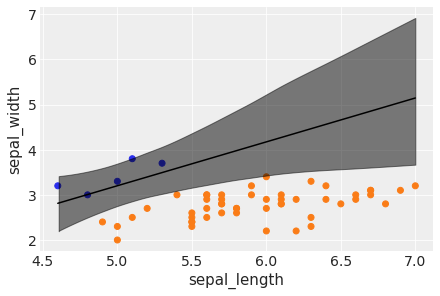

In [24]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 

plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hdi(x_3[:,0], trace_3['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Notes</b><br>
    <p style="color: black">
        (i) In case of an unbalanced dataset, logistic regression can run into some trouble: the boundary cannot be determined as accurately as when the dataset is more balanced. 
    </p>
    <p style="color: black">
        (ii) The decision boundary is "shifted" towards the less abundant class, and the uncertainty band is larger.
    </p>
    <p style="color: black">
        (iii) It is always good to have a balanced dataset. If you do have unbalanced data though, you should be careful when you interpret results: check the uncertainty of the model, and run some posterior predictive checks for consistency. Another option is to input more prior information if available and/or run an alternative model.  
    </p>    
   

</div>


## Generalization to multiple classes: Softmax Regression

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Notes</b><br>
    <p style="color: black">
        In order to generalize to mutliple classes, two modifications are needed: 
    </p>  
    <p style="color: black">
        (i) We use a softmax (see also Boltzmann distribution in physics), which is defined as:
    </p>
    <br></br>
    <center>
        $softmax_{i}(\mu)= \frac{exp(\mu_{i})}{\sum_{k}exp(\mu_{k})}$ 
    </center> 
    <p style="color: black">
        (ii) We then replace the Bernoulli distribution with the 
    <a href="https://en.wikipedia.org/wiki/Categorical_distribution">categorical distribution</a>.
    As the Bernoulli (single coin flip) is a special case of a Binomial (n coin flips), the categorical (single roll of a die) is a special case of the <a href="https://en.wikipedia.org/wiki/Multinomial_distribution">multinomial distribution</a> (n rolls of a die).
    </p>   

</div>


In [80]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values

x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

print(np.shape(x_s))

print(y_s)
print(x_n)
print(iris)

(150, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0   

In [62]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000, target_accept=.95)
    idata_s = az.from_pymc3(trace_s)

/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


In [63]:
data_pred = trace_s['μ'].mean(axis=0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

res_t = np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s)
print("accuracy is: {:1.3f}".format(res_t))


accuracy is: 0.980


In [64]:
from scipy.special import softmax 

In [65]:
y_pred2 = softmax(data_pred, axis=1)
res_t2 = np.sum(y_s == np.argmax(y_pred2, axis=1)) / len(y_s)
print("accuracy is: {:1.3f}".format(res_t2))

accuracy is: 0.980


In [78]:
az.summary(idata_s).head(15)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-1.135,3.746,-7.921,6.067,0.048,0.039,6080.0,5193.0,1.0
α[1],5.830,3.251,-0.181,11.987,0.044,0.031,5382.0,5418.0,1.0
α[2],-4.846,3.421,-11.267,1.436,0.046,0.035,5554.0,5354.0,1.0
"β[0, 0]",-2.604,4.099,-10.736,4.568,0.047,0.041,7711.0,5642.0,1.0
"β[0, 1]",1.985,3.267,-4.214,7.966,0.044,0.034,5404.0,4740.0,1.0
"β[0, 2]",0.640,3.265,-5.464,6.770,0.045,0.036,5341.0,5130.0,1.0
"β[1, 0]",3.186,3.414,-3.514,9.272,0.048,0.034,5167.0,5913.0,1.0
"β[1, 1]",-1.009,3.037,-7.135,4.367,0.045,0.032,4579.0,5063.0,1.0
"β[1, 2]",-2.408,3.057,-8.328,3.168,0.045,0.032,4636.0,5119.0,1.0
"β[2, 0]",-6.333,4.256,-14.192,1.548,0.047,0.036,8195.0,6219.0,1.0


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Notes</b><br>
    <p style="color: black">
        (i) 98% is the accuracy on our data; 
        <b>a true test to evaluate the performance of our model will be to check it on data not used to fit the model</b>
    </p>    
    <p style="color: black"> 
        (ii) You can check that we obtained a wide posterior. This is a result of the fact softmax normalizes probability to 1. Therefore, when we used priors on the parameters of 4 species, in reality we can "eliminate" one species" from the problem, in that one of them can be calculated from the other 3 once we know their probabilities (again, they have to sum up to 1!)
    </p>
    <p style="color: black"> 
        (iii) Below is a suggested solution, that does fix the extra parameters to some value, e.g., zero 
    </p>
    
    
   

</div>

In [89]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = pm.Deterministic('μ', α_f + pm.math.dot(x_s, β_f))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(2000, target_accept=.92)
    idata_sf = az.from_pymc3(trace_sf)

/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


In [90]:
data_pred_sf = trace_sf['μ'].mean(axis=0)

y_pred_sf = softmax(data_pred_sf, axis=1)
res_sf = np.sum(y_s == np.argmax(y_pred_sf, axis=1)) / len(y_s)
print("accuracy is: {:1.3f}".format(res_sf))


accuracy is: 0.973


In [95]:
#az.summary(idata_sf) --- it will complain as one value of mu is 0 by construction 

In [ ]:
cmpd_df = az.compare({'model_s':idata_s, 'model_sf': idata_sf}, method='BB-pseudo-BMA', ic='waic')

## Final remarks: Robust Logistic Regression (extra, for the curious...)

Let's take the dataset for the species setosa and versicolor only. 
Let's complicate the problem by assuming the presence of unusual seros and/or ones in our dataset.

Text(0.5, 0, 'sepal_length')

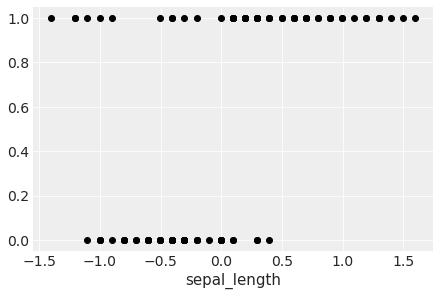

In [97]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');
plt.xlabel(x_n)

We have some versicolor (category 1) with some unusually short sepal_length... 

We can fix this with a **mixture model**. We say that the outpu variable comes with $\pi$ probability of random guessing (0.5 chance for category 1 to be indeed 1), and with 1-$\pi$ probability from a logistic regression model:

$p= \pi \ 0.5 + (1-\pi) \ logistic(\alpha+X\beta)$

Notice that when $\pi=1$, we get $p=0.5$ (random guess), whereas when $\pi=0$ we get the logistic regression. 

This model can be implemented with a slight modification of what we saw in mod2_part2. 

N.B. $\pi$ is a new variable in our model

In [101]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(2000, target_accept=0.95,  tune = 2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, β, α]


/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/cfanelli/Desktop/teaching/BRDS/jupynb_env_new/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameteri

([<matplotlib.axis.XTick at 0x2b1dc96a0>,
 [Text(-2.0, 0, '3.4'),
  Text(-1.5, 0, '3.9'),
  Text(-1.0, 0, '4.4'),
  Text(-0.5, 0, '4.9'),
  Text(0.0, 0, '5.4'),
  Text(0.5, 0, '5.9'),
  Text(1.0, 0, '6.4'),
  Text(1.5, 0, '6.9'),
  Text(2.0, 0, '7.4')])

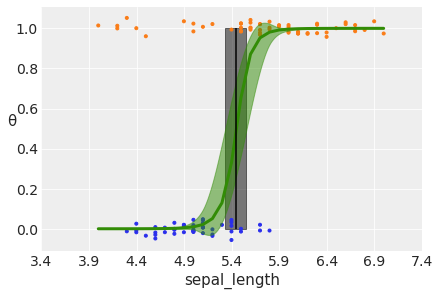

In [102]:
theta = trace_rlg.posterior['θ'].mean(axis=0).mean(axis=0)
idx = np.argsort(x_c)

np.random.seed(123)


plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(trace_rlg.posterior['bd'].mean(), 0, 1, color='k')

bd_hpd = az.hdi(trace_rlg.posterior['bd'])


plt.fill_betweenx([0, 1], bd_hpd.bd[0].values, bd_hpd.bd[1].values, color='k', alpha=0.5)


plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])


az.plot_hdi(x_c, trace_rlg.posterior['θ'], color='C2')  #green band 


plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))